In [1]:
import os
import rasterio as rio
import copy
import numpy as np
from osgeo import gdal
from osgeo import osr

In [2]:
# User inputs
ip_dir = 'LC08_L1TP_140043_20180109_20180119_01_T1'
band_nums = [6,4,7]       # Only Optical bands.

In [3]:
def ReferencedGeocode(refRas, npArray,op_file_name):
    # Checking extension of the output file
    if op_file_name.endswith('.tif'):
        None
    else:
        op_file_name = op_file_name + '.tif'
        
    # Getting info for geocoding
    xmin, ymin, xmax, ymax = refRas.bounds
    nrows,ncols = np.shape(npArray)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform = xmin, xres, 0, ymax, 0, -yres 
    epsg_num = int(refRas.crs.data['init'].split(':')[1])
    
    # Applying the geocoding
    output_raster = gdal.GetDriverByName('GTiff').Create(op_file_name, ncols, nrows, 1, gdal.GDT_Float32)  
    output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(epsg_num)
    output_raster.SetProjection(srs.ExportToWkt()) 
    output_raster.GetRasterBand(1).WriteArray(npArray)
    output_raster.FlushCache()
    
    return rio.open(op_file_name)

In [4]:
def toa2reflectance (ip_dir = ip_dir, band_nums = band_nums):
    bands_str = copy.copy(band_nums)
    # matching band numbers with Landsat-8 spec
    for i in range(len(bands_str)):
        bands_str[i] = 'B'+str(bands_str[i])
    
    # Getting metadata and list containing all raster bands   
    i = j = 0
    files = os.listdir(ip_dir)
    bandlist = []
    for file in files:
        # Getting the meta data
        if file.endswith("_MTL.txt"):
            i = i+1
            meta = []
            meta_file = open(os.path.join(ip_dir, file),"r")
            meta = meta_file.readlines()
            meta_file.close()

        for band_string in bands_str:
            if file.endswith('_' + band_string + '.TIF'):
                j = j+1
                curr_band = rio.open(os.path.join(ip_dir, file))
                bandlist.append(curr_band)

    # Checking the integrity of input files
    if i>1 or j>len(band_nums):
        raise Exception("Multiple input files within the input directory")
    if i==0 or j==0:
        raise Exception("Unable to find input files")
    del i, j
    
    # Extracting required parameters from metadata 
    mult_band = []
    add_band = []
    sun_ele = 0
    for line in meta:
        if sun_ele==0:
            if 'SUN_ELEVATION ' in line:
                sun_ele = float(line.split('=')[1])

        for band_num in band_nums:
            str_var = 'REFLECTANCE_MULT_BAND_' + str(band_num)+ ' '
            if str_var in line:
                mult_val = float(line.split('=')[1])
                mult_band.append(mult_val)

            str_var = 'REFLECTANCE_ADD_BAND_' + str(band_num)+ ' '
            if str_var in line:
                add_val = float(line.split('=')[1])
                add_band.append(add_val)
    
    # converting the bands to array, performing the conversion and storing the bands in a dictionary
    dictionary = dict.fromkeys(bands_str, 'pass') #MAKE DICT KEY IN FORMAT 'B1' instead of int(1)
    #reflectance = []  #optional
    for i in range(len(band_nums)):
        ras = np.empty(shape=(bandlist[i].shape))
        ras = bandlist[i].read(1).astype(float) 
        
        toa_np = (add_band[i] + (ras*mult_band[i]))/ np.sin(sun_ele)      #includes sun-angle correction
        toa = ReferencedGeocode(bandlist[i], toa_np, bands_str[i])
        dictionary[bands_str[i]] = toa
        #reflectance.append(toa)     #optional
    return dictionary

In [5]:
bands_dict = toa2reflectance()
bands_dict

{'B6': <open DatasetReader name='B6.tif' mode='r'>,
 'B4': <open DatasetReader name='B4.tif' mode='r'>,
 'B7': <open DatasetReader name='B7.tif' mode='r'>}

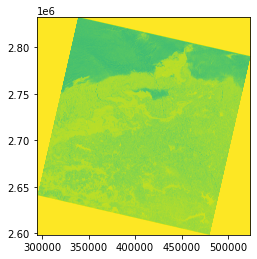

<AxesSubplot:>

In [6]:
from rasterio.plot import show
show(bands_dict['B7'])